+ 不要用 * ，矩阵乘就是 np.dot,元素乘就是np.multiply。不要用*，这玩意有二义性

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1  Logistic Regression

## 1.1  Visualizing the data

In [2]:
fpath = 'ex2data1.txt'
data1 = pd.read_csv(
    fpath,
    sep=',',
    header=None,
    names=['exam1_score','exam2_score','isAdmitted'])
data1_admitted = data1.loc[data1['isAdmitted'] == 1,:]
data1_noadmitted = data1.loc[data1['isAdmitted'] == 0,:]

print(
    data1.head(),
    data1_admitted.head(),
    data1_noadmitted.head(),sep='\n')

   exam1_score  exam2_score  isAdmitted
0    34.623660    78.024693           0
1    30.286711    43.894998           0
2    35.847409    72.902198           0
3    60.182599    86.308552           1
4    79.032736    75.344376           1
   exam1_score  exam2_score  isAdmitted
3    60.182599    86.308552           1
4    79.032736    75.344376           1
6    61.106665    96.511426           1
7    75.024746    46.554014           1
8    76.098787    87.420570           1
    exam1_score  exam2_score  isAdmitted
0     34.623660    78.024693           0
1     30.286711    43.894998           0
2     35.847409    72.902198           0
5     45.083277    56.316372           0
10    95.861555    38.225278           0


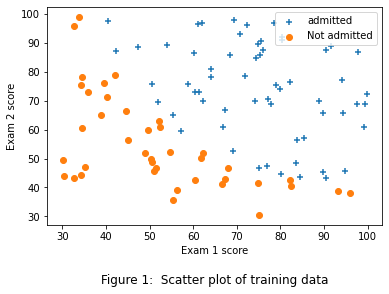

In [3]:
plt.scatter(data1_admitted['exam1_score'],data1_admitted['exam2_score'],marker='+',label='admitted')
plt.scatter(data1_noadmitted['exam1_score'],data1_noadmitted['exam2_score'],marker='o',label='Not admitted')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.title('Figure 1:  Scatter plot of training data',y=-0.3)
plt.legend(loc=1)
plt.show()

## 1.2  Implementation

### 1.2.1  Warmup exercise: sigmoid function

In [4]:
def sigmoidFunction(x):
    return  1/(1+np.exp(-x))
print(sigmoidFunction(0),sigmoidFunction(np.matrix(np.zeros(shape=(2,2)))),sep='\n')

0.5
[[0.5 0.5]
 [0.5 0.5]]


### 1.2.2  Cost function and gradient

In [5]:
def costFunction(theta,X,y): # 注意顺序，本来参数顺序无所谓的，但是下面 op.minimize 拟合的时候需要注重参数的位置，所以顺序成了 theta,X,y了
    m = X.shape[0]
    # log 的底数？
    return (-y.T.dot(np.log(sigmoidFunction(X.dot(theta)))) - (1-y).T.dot(np.log(1 - sigmoidFunction(X.dot(theta))))) / m

In [6]:
data1.insert(0,'ones',1)
cols = data1.shape[1]
X = np.matrix(data1.iloc[:,0:cols - 1])
y = np.matrix(data1.iloc[:,cols-1:cols])
theta = np.matrix(np.zeros(shape=(cols-1,1)))

In [7]:
print(costFunction(theta,X,y))

[[0.69314718]]


  虽然没要求，不过还是写出来梯度下降函数，但是很遗憾的是不能用，原因为用梯度下降算出来的 theta（我也不知道是否正确），无法计算其 costFunction，原因在于 sigmoidFunction 由于有np.exp()，所以经常得到的结果为0，然而0又不能带入到 log 中，所以出错。
  
  当然也有可能是我的思路或者代码问题。。总之这里我用梯度下降算出的 theta 无法保证正确。
  
  --
  
  2021-1-22 更新：
  在下文通过 gradientDescent2 函数的测试，发现其实是 alpha 的值太大了导致 costJ 发散，alpha只能为10$^{-3}$这一量级以及以下。。 比这个量级高的都发散了。。

In [8]:
# 梯度下降函数，但是不能用 --> 能用了。。。之前学习率太大并且循环次数太小了。。。
def gradientDescent(theta,X,y,alpha,iters):
    m,n = X.shape
    for k in range(iters):
        new_theta = np.matrix(np.zeros(shape=(n,1)))
        new_theta = theta - alpha/m * ( X.T.dot(sigmoidFunction(X.dot(theta)) - y) )
        theta = new_theta
    return theta,costFunction(theta,X,y)   # costFunction(X,y,theta) 报错。。

In [9]:
theta = np.matrix(np.zeros(shape=(cols-1,1)))
theta,costF = gradientDescent(theta,X,y,0.003,400000) 
print(theta,costF)

[[-19.37101227]
 [  0.15996447]
 [  0.154604  ]] [[0.20970157]]


不过注意作业，让算的是**梯度函数(也就是只算偏导数)**

In [10]:
def gradient(theta,X,y):
    m,n = X.shape
    theta = theta.reshape(n,1)        # !!!!! 相当重要，太重要了，就在这坑的，没有的话 theta.shape 会变成 (3,)
    return (X.T.dot(sigmoidFunction(X.dot(theta)) - y))/m

### 1.2.3  Learning parameters usingfminunc

+ 参考：[Python fminunc 的替代方法](https://blog.csdn.net/csdn_inside/article/details/81558079)

In [11]:
import scipy.optimize as op

In [12]:
# op.minimize 的参数x0,args需要转成 np.ndarray，而不能是np.matrix
X = np.array(X)
y = np.array(y)
theta = np.array(np.matrix(np.zeros(shape=(cols-1,1))))
res = op.minimize(fun=costFunction, x0=theta, args=(X, y), method='TNC', jac=gradient)
print(res)

     fun: array([0.2034977])
     jac: array([[9.14875519e-09],
       [9.99037356e-08],
       [4.79345707e-07]])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 36
     nit: 17
  status: 0
 success: True
       x: array([-25.16131853,   0.20623159,   0.20147149])


  上面内篇博文最后提到了其实梯度下降也可以，但是需要一个好的学习率，而且终止条件改成判断J的值

In [13]:
# gradientDescent:版本2
def gradientDescent2(theta,X,y,alpha):
    m,n = X.shape
    costJ = 1
    i = 0       # 好奇，看下循环次数
    while costJ > 0.21:
        new_theta = np.matrix(np.zeros(shape=(n,1)))
        new_theta = theta - alpha/m * ( X.T.dot(sigmoidFunction(X.dot(theta)) - y) )
        theta = new_theta
        costJ = costFunction(theta,X,y)
        i = i + 1
    return i,theta,costJ   # costFunion(X,y,theta) 报错。。

In [14]:
X = np.matrix(data1.iloc[:,0:cols - 1])
y = np.matrix(data1.iloc[:,cols-1:cols])
theta = np.matrix(np.zeros(shape=(cols-1,1)))
i,theta,costJ = gradientDescent2(theta,X,y,0.003)    # alpha = 0.001 -> iters = 206,5035 ; alpha = 0.003 -> iters = 383261 ;只能到这一量级,alpha = 0.01的话就发散了

将 h_theta 函数画在图上：其实就是找h_theta = 0.5 时的边界，当 h_theta = 0.5时，其方程化简为 theta.T.dot(x) = 0

需要注意的就是使用哪个 theta，是 gradientDescent,还是 gradientDescent2,还是 op.minimize。

按照作业需求应该用minimize，当然其实差别没那么大。

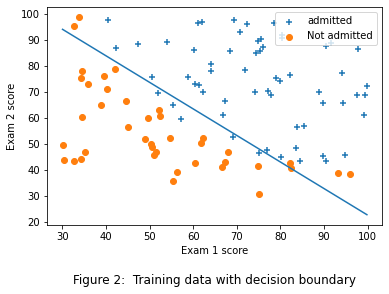

In [15]:
theta = np.matrix(res.x)
theta = theta.T
x1 = np.linspace(data1['exam1_score'].min(),data1['exam1_score'].max(),2)
x2 = (-theta[0,0]-theta[1,0]*x1)/theta[2,0]
plt.plot(x1,x2)
plt.scatter(data1_admitted['exam1_score'],data1_admitted['exam2_score'],marker='+',label='admitted')
plt.scatter(data1_noadmitted['exam1_score'],data1_noadmitted['exam2_score'],marker='o',label='Not admitted')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.title('Figure 2:  Training data with decision boundary',y=-0.3)
plt.legend(loc=1)
plt.show()

### 1.2.4  Evaluating logistic regression

第一种评估方法：you can use the model to predict whether aparticular  student  will  be  admitted.   For  a  student  with  an  Exam  1  scoreof  45  and  an  Exam  2  score  of  85,  you  should  expect  to  see  an  admissionprobability of 0.776.

In [16]:
x = np.matrix([1,45,85])
sigmoidFunction(x.dot(theta))

matrix([[0.77629062]])

第二种评估方法：查看与原始数据相比的正确率

In [17]:
def predict(theta,X):
    predictions = sigmoidFunction(X.dot(theta))
    return [1 if x > 0.5 else 0 for x in predictions]

In [18]:
theta = np.matrix(res.x).T
predictions = np.matrix(predict(theta,X))
predictions = predictions.reshape(100,1)
correct = y - predictions
print('精确度：'+ str(sum(correct == 0)[0,0] / len(correct)))

精确度：0.89


# 2  Regularized logistic regression

2021-1-23：说实话到目前为止只是听懂了正则化的意义是为了解决**过拟合**和**欠拟合**的问题，但并没有理解了为什么要对所有的 theta(当然除了theta0) 进行相同程度的正则化，如果只是为了减轻权重的话那相同程度的缩放每个theta的权重应该不会变啊。

## 2.1  Visualizing the data

In [19]:
fpath = 'ex2data2.txt'
data2 = pd.read_csv(fpath,header=None,sep=',',names=['Microchip Test 1','Microchip Test 2','isAccepted'])
data2.head()

,Microchip Test 1,Microchip Test 2,isAccepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [20]:
data2_accepted = data2.loc[data2['isAccepted'] == 1,:]
data2_rejected = data2.loc[data2['isAccepted'] == 0,:]
print(data2_accepted.head(),data2_rejected.head(),sep='\n')

   Microchip Test 1  Microchip Test 2  isAccepted
0          0.051267           0.69956           1
1         -0.092742           0.68494           1
2         -0.213710           0.69225           1
3         -0.375000           0.50219           1
4         -0.513250           0.46564           1
    Microchip Test 1  Microchip Test 2  isAccepted
58           0.18376           0.93348           0
59           0.22408           0.77997           0
60           0.29896           0.61915           0
61           0.50634           0.75804           0
62           0.61578           0.72880           0


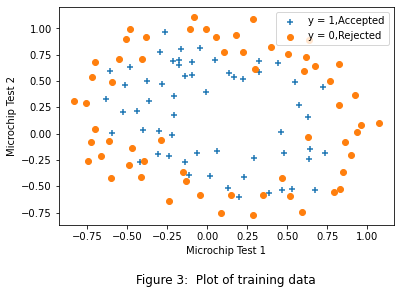

In [21]:
plt.scatter(data2_accepted['Microchip Test 1'],data2_accepted['Microchip Test 2'],marker='+',label='y = 1,Accepted')
plt.scatter(data2_rejected['Microchip Test 1'],data2_rejected['Microchip Test 2'],marker='o',label='y = 0,Rejected')
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.title('Figure 3:  Plot of training data',y=-0.3)
plt.legend(loc=1)
plt.show()

## 2.2  Feature mapping

we will map the features into all polynomial terms of x1 and x2 up to the sixth power 

The result is a 28-dimensional vector

In [22]:
# 对 data 进行加工
def mapFeature(data,n):
    data.insert(0,'ones',1)
    cols = data2.shape[1]
    X = data.iloc[:,0:cols-1]
    y = data.iloc[:,cols-1:cols]
    for i in range(2,n+1):
        for j in range(i+1):
            X.loc[:,'x1^'+str(j)+" * "+'x2^'+str(i-j)] = np.multiply(np.power(X.iloc[:,1],j),np.power(X.iloc[:,2],i-j))
    X = np.matrix(X)
    y = np.matrix(y)
    theta = np.matrix(np.zeros(shape=(X.shape[1],1)))
    return theta,X,y

In [23]:
theta,X,y = mapFeature(data2,6)
print(theta.shape,X.shape,y.shape)

(28, 1) (118, 28) (118, 1)


## 2.3  Cost function and gradient

In [24]:
lambda_var = 0 
def regularizedCostFunction(theta,X,y,lambda_var):
    m,n = X.shape
    theta = theta.reshape(n,1)     # 以防万一改了 theta.shape
    temp_theta = theta.copy()
    temp_theta[0] = 0               # 不惩罚 theta0
    return costFunction(theta,X,y) + lambda_var/(2*m) * (temp_theta.T.dot(temp_theta))
regularizedCostFunction(theta,X,y,lambda_var)

matrix([[0.69314718]])

In [25]:
def regularizedGradient(theta,X,y,lambda_var):
    m,n = X.shape
    theta = theta.reshape(n,1)     # 同以防万一
    temp_theta = theta.copy()
    temp_theta[0] = 0
    return gradient(theta,X,y) + lambda_var/m * temp_theta

In [26]:
regularizedGradient(theta,X,y,lambda_var)

matrix([[8.47457627e-03],
        [1.87880932e-02],
        [7.77711864e-05],
        [3.76648474e-02],
        [1.15013308e-02],
        [5.03446395e-02],
        [2.34764889e-02],
        [8.19244468e-03],
        [7.32393391e-03],
        [1.83559872e-02],
        [3.93028171e-02],
        [3.09593720e-03],
        [1.28600503e-02],
        [2.23923907e-03],
        [3.93486234e-02],
        [3.10079849e-02],
        [4.47629067e-03],
        [5.83822078e-03],
        [3.38643902e-03],
        [4.32983232e-03],
        [1.99707467e-02],
        [3.87936363e-02],
        [1.37646175e-03],
        [7.26504316e-03],
        [4.08503006e-04],
        [6.31570797e-03],
        [1.09740238e-03],
        [3.10312442e-02]])

### 2.3.1  Learning parameters usingfminunc

In [27]:
# op.minimize 的参数x0,args需要转成 np.ndarray，而不能是np.matrix
X = np.array(X)
y = np.array(y)
theta = np.array(np.zeros(shape=(X.shape[1],1)))

# 卧槽，lambda 的值并不是过了某一个临界值就开始收敛，值为1,10的时候可以，为0,1000,10000的时候不可，但是为 1000000 的时候又能收敛了。。。。
res = op.minimize(fun=regularizedCostFunction, x0=theta, args=(X, y,1), method='TNC', jac=regularizedGradient) 
print(res)

     fun: array([[0.52900273]])
     jac: array([[-2.14886578e-06],
       [ 6.79569531e-07],
       [-3.48479795e-07],
       [-9.33009615e-07],
       [-4.08668431e-08],
       [ 8.76358868e-07],
       [-9.72295768e-07],
       [ 1.56028213e-08],
       [ 1.72030635e-08],
       [-5.14462024e-07],
       [ 2.33667196e-07],
       [ 1.79649839e-07],
       [-2.79154968e-07],
       [ 3.55161949e-08],
       [ 6.96965947e-08],
       [-1.48136699e-06],
       [-5.27484610e-08],
       [-9.30351871e-08],
       [ 6.16731938e-07],
       [-2.11475980e-07],
       [ 1.47243044e-07],
       [-7.34528221e-07],
       [ 1.64746715e-08],
       [-4.12373023e-07],
       [-7.16275015e-08],
       [-1.32102103e-07],
       [ 1.80322238e-07],
       [ 2.31249038e-07]])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 32
     nit: 7
  status: 1
 success: True
       x: array([ 1.27271027,  0.62529965,  1.18111686, -1.43166929, -0.9174319 ,
       -2.01987399, -0.17516291, -0.35725403, -0.365

## 2.4  Plotting the decision boundary

In [28]:
theta = np.array(res.x)
theta

array([ 1.27271027,  0.62529965,  1.18111686, -1.43166929, -0.9174319 ,
       -2.01987399, -0.17516291, -0.35725403, -0.36553118,  0.12393227,
       -1.19271298, -0.27469165, -0.61558551, -0.05098418, -1.4581701 ,
       -0.45645982, -0.29539513, -0.27778953, -0.04466178, -0.20603295,
       -0.2421784 , -0.92467487, -0.14389151, -0.32742407,  0.01555761,
       -0.29244874,  0.02779373, -1.04319156])

虽然 Decision Boundary 表面看起来判定还是 theta.T * x = 0，但是 theta 和 x 都是 28维的向量了，并且 x1 和 x2的对应关系应该是多对多

自己笨蛋，画不出来，找到一篇参考文章：[吴恩达机器学习练习2.2——python实现代码详解](https://www.bilibili.com/read/cv7256459/)，它的思想是将整个区域分成许多个小区域（比如将x等分成50份，y也等分成50份，然后判断每一个等分过后的点的 theta.T * x 是否为 0 ，这样就找出了满足边界值的点，然后连起来）。**跟微分的思想一样。**

In [29]:
def plotDecisionBoundary(m,theta):    # m:区域分成 m * m 份
    u = np.linspace(-1,1.5,m)   # 横坐标
    v = np.linspace(-1,1.5,m)   # 纵坐标
    z = np.zeros((len(u),len(v))) # 坐标点
    myData= pd.DataFrame(columns=['x','y','0'],dtype='float64') # 第三列没用，要他是因为我前面写的mapFeature需要的Data是三列
    
    for i in range(len(v)):        # 外循环是遍历v的
        for j in range(len(u)):    # 内循环是遍历u的
            # 所以这里是u[j] 和 v[i]，而不是u[i]，和v[j]
            myData = myData.append(pd.DataFrame({'x':u[j],'y':v[i],'0':0},index=[1],dtype='float64'),ignore_index=True)
    
    myData_theta,myData_X,myData_y = mapFeature(myData,6)
    myData = np.array(myData_X) # 只需要 X,另外两个都不需要
    # print(myData.dtype,X.dtype)
    myData = sigmoidFunction(myData.dot(theta))
    k = 0
    for i in range(len(v)):
        for j in range(len(u)):
            z[i,j] = myData[k]
            k = k + 1
    
    
    '''
    z = np.transpose(z)：加这句话是因为 plt.contour 规定横纵坐标相反？？？ 为什么？？
    
    Answer：不是contour 规定相反，而是 z 之前就被搞反了，y是相当于第一维，x相当于第二维，
    但是在参考的代码中初始化的时候却是外循环是x，内循环是外导致的反了。
    
    我上面改过来这个问题了，自然也就不需要这句话了。

    '''
#     z = np.transpose(z) # np.transpose(z) [Python numpy.transpose 详解](https://www.cnblogs.com/xiaoboge/p/9682364.html)
    return u,v,z

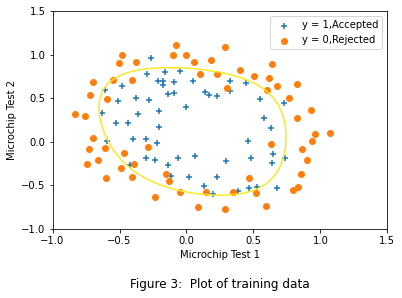

In [30]:
plt.scatter(data2_accepted['Microchip Test 1'],data2_accepted['Microchip Test 2'],marker='+',label='y = 1,Accepted')
plt.scatter(data2_rejected['Microchip Test 1'],data2_rejected['Microchip Test 2'],marker='o',label='y = 0,Rejected')
u,v,z = plotDecisionBoundary(50,theta)
plt.contour(u,v,z,[0,0.5])
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.title('Figure 3:  Plot of training data',y=-0.3)
plt.legend(loc=1)
plt.show()

下面这个是我用来测试 plt.contour() 的，请忽略它。

[[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
 [ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19.]
 [ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]
 [ 3.  5.  7.  9. 11. 13. 15. 17. 19. 21.]
 [ 4.  6.  8. 10. 12. 14. 16. 18. 20. 22.]
 [ 5.  7.  9. 11. 13. 15. 17. 19. 21. 23.]
 [ 6.  8. 10. 12. 14. 16. 18. 20. 22. 24.]
 [ 7.  9. 11. 13. 15. 17. 19. 21. 23. 25.]
 [ 8. 10. 12. 14. 16. 18. 20. 22. 24. 26.]
 [ 9. 11. 13. 15. 17. 19. 21. 23. 25. 27.]]


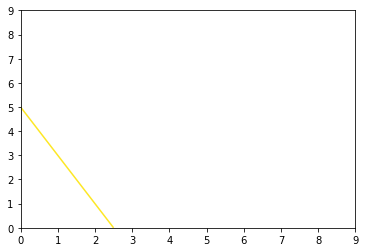

In [31]:
test_x = np.linspace(0,9,10)
test_y = np.linspace(0,9,10)
test_z = np.zeros(shape=(10,10))
for i in range(10):
    for j in range(10):
        test_z[i,j] = test_x[j]*2 + test_y[i]
print(test_z)
plt.contour(test_z,[0,5])
plt.show()

算一下预测的正确率

In [32]:
theta = np.matrix(res.x).T
predictions = np.matrix(predict(theta,X))
predictions = predictions.reshape(118,1)
correct = y - predictions
print('精确度：'+ str(sum(correct == 0)[0,0] / len(correct)))

精确度：0.8305084745762712


## 2.5  Optional (ungraded) exercises

lambda_var = 0 :

     fun: array([[0.25321009]])
     jac: array([[ 4.10752171e-04],
       [-2.02484369e-04],
       [-9.23945297e-04],
       [ 7.27070169e-05],
       [-2.19800121e-04],
       [ 5.43362492e-05],
       [-1.10352263e-05],
       [-1.18483310e-05],
       [-8.54315550e-05],
       [-4.37212689e-06],
       [ 3.11886262e-05],
       [-1.32651200e-04],
       [ 4.85229996e-05],
       [-7.96528447e-05],
       [-1.79225662e-05],
       [ 2.48125954e-05],
       [-3.73207413e-05],
       [-1.08116751e-05],
       [-3.18148823e-05],
       [-7.15697525e-06],
       [-3.07346706e-06],
       [ 4.08106389e-05],
       [-4.77361368e-05],
       [ 1.24430717e-05],
       [-1.94954679e-05],
       [-1.04546959e-05],
       [-1.30593738e-05],
       [-1.91228069e-05]])
 message: 'Max. number of function evaluations reached'
    nfev: 280
     nit: 28
  status: 3
 success: False
       x: array([   13.0961957 ,    15.73969936,     4.46359343,   -59.76863539,
         -62.32271015,  -134.07780629

E:\Anaconda3\envs\CourseraMLAndrewNgmyNoteEnv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


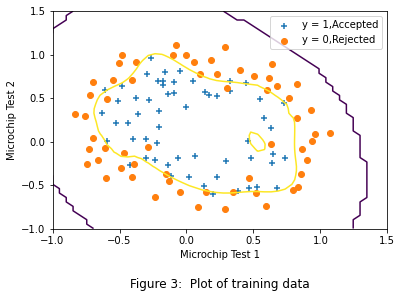

In [33]:
theta = np.array(np.zeros(shape=(X.shape[1],1)))
res = op.minimize(fun=regularizedCostFunction, x0=theta, args=(X, y,0), method='TNC', jac=regularizedGradient)  # 这一步 res 就已经因为欠拟合而失败了，所以下面的结果都是在失败的基础上得出来的的
print(res)
theta = np.array(res.x)

plt.scatter(data2_accepted['Microchip Test 1'],data2_accepted['Microchip Test 2'],marker='+',label='y = 1,Accepted')
plt.scatter(data2_rejected['Microchip Test 1'],data2_rejected['Microchip Test 2'],marker='o',label='y = 0,Rejected')
u,v,z = plotDecisionBoundary(50,theta)
plt.contour(u,v,z,[0,0.5])
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.title('Figure 3:  Plot of training data',y=-0.3)
plt.legend(loc=1)
plt.show()

lambda_var = 100 ：

     fun: array([[0.68648383]])
     jac: array([[ 1.57001835e-07],
       [ 2.63073714e-08],
       [-1.14658239e-07],
       [-9.65351148e-08],
       [ 2.14487938e-08],
       [-1.68034471e-08],
       [-6.86829252e-08],
       [ 8.99513934e-09],
       [-7.69174524e-10],
       [ 7.47452244e-09],
       [-4.84726148e-08],
       [ 3.77826592e-09],
       [ 6.78177465e-09],
       [-2.47908113e-09],
       [ 1.95482643e-08],
       [-5.39804776e-08],
       [ 4.45191988e-09],
       [ 1.43017846e-09],
       [ 1.97948498e-09],
       [ 1.16735796e-09],
       [ 1.00257607e-08],
       [-4.41524904e-08],
       [-4.10178644e-10],
       [ 4.04418180e-09],
       [-2.01962252e-09],
       [ 6.57755056e-09],
       [-3.62508075e-09],
       [ 1.95335123e-08]])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 11
     nit: 3
  status: 1
 success: True
       x: array([ 0.02187847, -0.0174817 ,  0.00571065, -0.03859873, -0.01314874,
       -0.05516901, -0.02280461, -0.00892429, -0.007

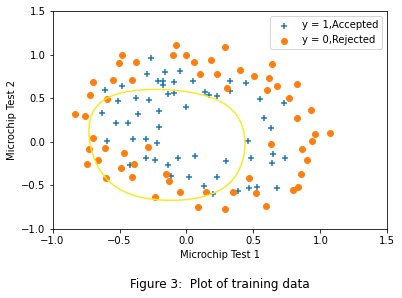

精确度：0.6101694915254238


In [34]:
theta = np.array(np.zeros(shape=(X.shape[1],1)))
res = op.minimize(fun=regularizedCostFunction, x0=theta, args=(X, y,100), method='TNC', jac=regularizedGradient) #虽然拟合成功，但是精确率太低
print(res)
theta = np.array(res.x)

plt.scatter(data2_accepted['Microchip Test 1'],data2_accepted['Microchip Test 2'],marker='+',label='y = 1,Accepted')
plt.scatter(data2_rejected['Microchip Test 1'],data2_rejected['Microchip Test 2'],marker='o',label='y = 0,Rejected')
u,v,z = plotDecisionBoundary(50,theta)
plt.contour(u,v,z,[0,0.5])
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.title('Figure 3:  Plot of training data',y=-0.3)
plt.legend(loc=1)
plt.show()

theta = np.matrix(res.x).T
predictions = np.matrix(predict(theta,X))
predictions = predictions.reshape(118,1)
correct = y - predictions
print('精确度：'+ str(sum(correct == 0)[0,0] / len(correct)))

# END